In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os

In [3]:
# Data from: https://mmspg.epfl.ch/dowloads/food-image-datasets/
#!wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
# --ftp-password Cahclmoo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://archive.org/download/food-5-k/Food-5K.zip

--2025-02-28 16:59:58--  https://archive.org/download/food-5-k/Food-5K.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601606.us.archive.org/13/items/food-5-k/Food-5K.zip [following]
--2025-02-28 16:59:59--  https://ia601606.us.archive.org/13/items/food-5-k/Food-5K.zip
Resolving ia601606.us.archive.org (ia601606.us.archive.org)... 207.241.227.86
Connecting to ia601606.us.archive.org (ia601606.us.archive.org)|207.241.227.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  38.9MB/s    in 6.9s    

2025-02-28 17:00:06 (62.0 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [4]:
! unzip -qq -o Food-5K.zip

In [5]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!ls Food-5K

evaluation  training  validation


In [7]:
!ls Food-5K/training

0_0.jpg     0_1338.jpg	0_325.jpg  0_663.jpg  1_0.jpg	  1_1338.jpg  1_325.jpg  1_663.jpg
0_1000.jpg  0_1339.jpg	0_326.jpg  0_664.jpg  1_1000.jpg  1_1339.jpg  1_326.jpg  1_664.jpg
0_1001.jpg  0_133.jpg	0_327.jpg  0_665.jpg  1_1001.jpg  1_133.jpg   1_327.jpg  1_665.jpg
0_1002.jpg  0_1340.jpg	0_328.jpg  0_666.jpg  1_1002.jpg  1_1340.jpg  1_328.jpg  1_666.jpg
0_1003.jpg  0_1341.jpg	0_329.jpg  0_667.jpg  1_1003.jpg  1_1341.jpg  1_329.jpg  1_667.jpg
0_1004.jpg  0_1342.jpg	0_32.jpg   0_668.jpg  1_1004.jpg  1_1342.jpg  1_32.jpg	 1_668.jpg
0_1005.jpg  0_1343.jpg	0_330.jpg  0_669.jpg  1_1005.jpg  1_1343.jpg  1_330.jpg  1_669.jpg
0_1006.jpg  0_1344.jpg	0_331.jpg  0_66.jpg   1_1006.jpg  1_1344.jpg  1_331.jpg  1_66.jpg
0_1007.jpg  0_1345.jpg	0_332.jpg  0_670.jpg  1_1007.jpg  1_1345.jpg  1_332.jpg  1_670.jpg
0_1008.jpg  0_1346.jpg	0_333.jpg  0_671.jpg  1_1008.jpg  1_1346.jpg  1_333.jpg  1_671.jpg
0_1009.jpg  0_1347.jpg	0_334.jpg  0_672.jpg  1_1009.jpg  1_1347.jpg  1_334.jpg  1_672.jpg
0_100.jpg   0_1

In [8]:
!mv Food-5K/* .

In [9]:
!ls

evaluation  Food-5K  Food-5K.zip  __MACOSX  sample_data  training  validation


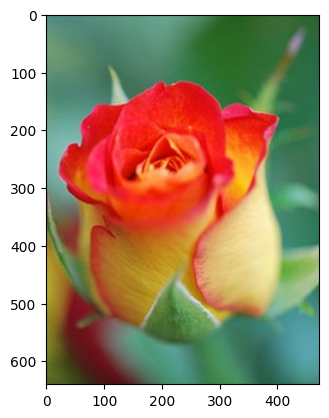

In [10]:
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

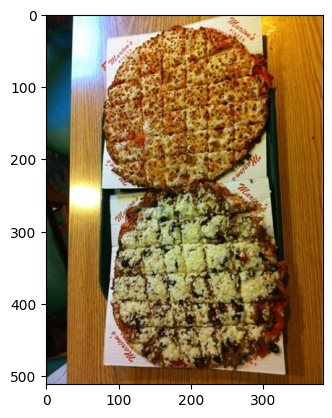

In [12]:
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [13]:
!mkdir data

In [14]:
!ls

data  evaluation  Food-5K  Food-5K.zip	__MACOSX  sample_data  training  validation


In [15]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [16]:
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [17]:
train_path = 'data/train'
valid_path = 'data/test'

In [18]:
IMAGE_SIZE =[200,200]

In [19]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [20]:
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

In [29]:
K = len(folders)
K

2

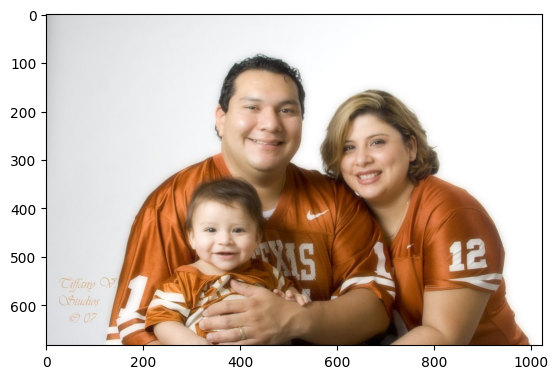

In [24]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [25]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
ptm.trainable = False

In [27]:
# data augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1)
]
)

In [30]:
# Build the model using the functional API
i = Input(shape=IMAGE_SIZE + [3])
x = preprocess_input(i)
x = data_augmentation(i)
x = ptm(x)
x = Flatten()(x)
x = Dense(K, activation='softmax')(x)
model = Model(inputs=i, outputs=x)

In [37]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [32]:
batch_size =128

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
# fit the model
r = model.fit(
    train_ds,
    validation_data=val_ds, # Changed 'validation' to 'validation_data'
    epochs=10
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 956ms/step - accuracy: 0.7081 - loss: 8.1417 - val_accuracy: 0.9450 - val_loss: 1.4037
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 528ms/step - accuracy: 0.9493 - loss: 0.9579 - val_accuracy: 0.9610 - val_loss: 1.0754
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.9573 - loss: 0.6829 - val_accuracy: 0.9530 - val_loss: 1.0569
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - accuracy: 0.9581 - loss: 0.6797 - val_accuracy: 0.9590 - val_loss: 1.0993
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step - accuracy: 0.9668 - loss: 0.4501 - val_accuracy: 0.9570 - val_loss: 0.9583
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 540ms/step - accuracy: 0.9598 - loss: 0.5108 - val_accuracy: 0.9640 - val_loss: 1.1182
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 545ms/step - accuracy: 0.9715 - loss: 0.3734 - val_accuracy: 0.9600 - val_loss: 1.0143
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.9784 - loss: 0.2996 - val_accu

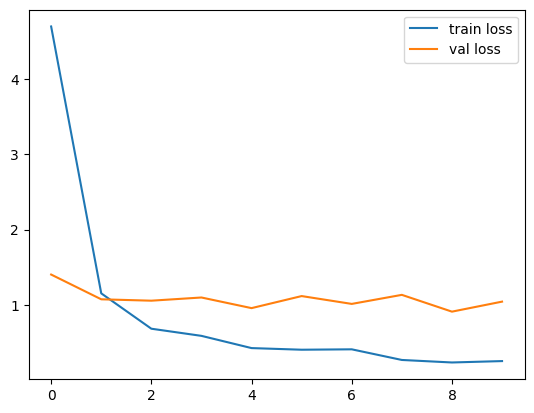

In [40]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

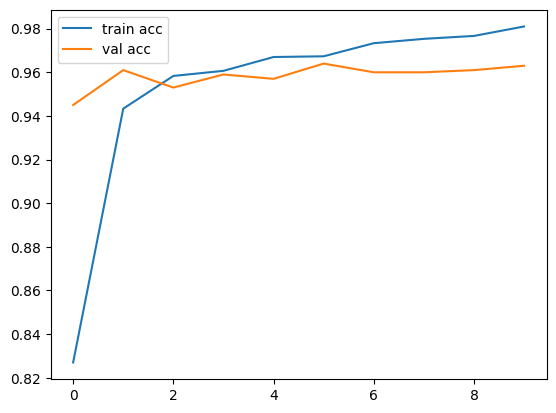

In [41]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [42]:
# Exercise:
# Try without data augmentation
# This means you can pass in images through pretrained model
# only once